## 项目目标： 实现基于rnn的名字分类器
### 总体过程  输入-> 嵌入-> GRU -> 线性层 -> 输出

#### 加载依赖库

In [ ]:
import torch
import gzip # 打开gz文件的依赖包
import csv
import time
import math

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pack_sequence,pad_packed_sequence

#### 创建数据类

In [ ]:
class NameDataset(Dataset):
    def __init__(self,is_train_set = True):
        filename = 'names_train.csv.gz' if is_train_set else 'names_test.csv.gz' 
        with gzip.open(filename, 'rt') as f:
            reader = csv.reader(f)
            rows = list(reader)
        # 生成人名数据
        self.names = [row[0] for row in rows]
        self.countries = [row[1] for row in rows]
        self.seq_num = len(self.names)
        # 生成国家数据
        self.country_list = list(sorted(set(self.countries)))
        # print("zhouyuzhe:   ",self.country_list)
        self.country_dict = self.getCountryDict()
        self.country_num = len(self.country_list)

    
    # 生成关于国家的字典  在类方法中  参数必须有self 否则参数会报错的
    def getCountryDict(self):
        country_dict = dict()
        for idx, country_name in enumerate(self.country_list, 0):
            country_dict[country_name] = idx
        return country_dict
    
    def __getitem__(self,index):
        # 访问list数据  需要使用[]
        return self.names[index],self.country_dict[self.countries[index]]

    def __len__(self):
        # 返回数据集的长度
        return self.seq_num
        
    def idx2country(self, index):
        return self.country_list[index]
        
    def getCountriesNum(self):
        return self.country_num


#### 搭建模型

In [ ]:
class RnnClassidier(torch.nn.Module):
    def __init__(self, input_size, hidden_size,output_size, n_layers = 1, bidirectional = True):
        super(RnnClassidier,self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.directional = 2 if bidirectional else 1

        # 对词向量进行嵌入
        self.embedding = torch.nn.Embedding(input_size,hidden_size)

        # 使用gru进行处理
        self.Gru = torch.nn.GRU(hidden_size,hidden_size,n_layers,bidirectional= bidirectional)

        # 构建全连接网络作为分类器
        self.fc = torch.nn.Linear(hidden_size* self.directional,output_size)

    # 生成rnn的第一个输入h0
    def _init_hidden(self,batch_size):
        hidden = torch.zeros(self.n_layers * self.directional,batch_size,self.hidden_size)
        return hidden

    # 前向传播
    def forward (self, input, seq_lengths):
        # 先对input进行转置处理
        input = input.t()
        # 得到batch_size
        batch_size = input.size(1)
        # 生成隐藏的维度h0
        hidden  = self._init_hidden(batch_size= batch_size)
        # 进行词嵌入 
        embedding = self.embedding(input)
        # 进行padded
        gru_inputs = pack_padded_sequence(embedding,seq_lengths)
        # 开始使用gru进行计算
        output, hidden = self.Gru(gru_inputs, hidden)
        # 如果是双向的 拼接
        if self.directional == 2:
            hidden_cat = torch.cat([hidden[-1], hidden[-2]], dim=1)
        else:
            hidden_cat = hidden[-1]
        # 使用全连接网络预测
        fc_output = self.fc(hidden_cat)
        return fc_output

#### 将字符串数据进行转化

In [ ]:
# 得到字母的ascll码值
def name2list(name):
    arr = [ord(c) for c in name]
    return arr, len(arr)

def make_tensors(names, countries):
    # 将名字转换成ascll码和名字的长度 list
    sequences_and_lengths = [name2list(name) for name in names]
    # 拿到名字的ascll码值
    name_sequences = [sl[0] for sl in sequences_and_lengths]
    # 拿到序列长度
    seq_lengths = torch.LongTensor([sl[1] for sl in sequences_and_lengths])
    countries = countries.long()
    # make tensor of name, BatchSize x SeqLen
    seq_tensor = torch.zeros(len(name_sequences), seq_lengths.max()).long()
    for idx, (seq, seq_len) in enumerate(zip(name_sequences, seq_lengths), 0):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)
    # sort by length to use pack_padded_sequence
    seq_lengths, perm_idx = seq_lengths.sort(dim=0, descending=True)
    seq_tensor = seq_tensor[perm_idx]
    countries = countries[perm_idx]
    return seq_tensor, seq_lengths,countries


#### 模型训练模块

In [ ]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def trainModel():
    total_loss = 0
    for i, (names, countries) in enumerate(trainloader, 1):
        inputs, seq_lengths, target = make_tensors(names, countries)
        # 使用分类器进行计算
        output = classifier(inputs, seq_lengths)
        # 正向计算损失
        loss = criterion(output, target)
        # 优化器梯度归零
        optimizer.zero_grad()
        # 反向传播梯度
        loss.backward()
        # 执行优化过程
        optimizer.step()
        # 损失求和
        total_loss += loss.item()
        
        if i % 10 == 0:
            print(f'[{time_since(start)}] Epoch {epoch} ', end='')
            print(f'[{i * len(inputs)}/{len(trainset)}] ', end='')
            print(f'loss={total_loss / (i * len(inputs))}')
    return total_loss

#### 模型测试模块

In [ ]:
def testModel():
    correct = 0
    total = len(testset)
    print("evaluating trained model ...")
    # 在利用模型进行测试的时候不需要进行梯度的计算
    with torch.no_grad():
        for i, (names, countries) in enumerate(testloader, 1):
            inputs, seq_lengths, target = make_tensors(names, countries)
            output = classifier(inputs, seq_lengths)
            pred = output.max(dim=1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            percent = '%.2f' % (100 * correct / total)
            # print(f'Test set: Accuracy {correct}/{total} {percent}%')
    return correct / total

In [ ]:
# 参数的初始化
HIDDEN_SIZE = 2
BATCH_SIZE = 256
N_LAYER = 2
N_EPOCHS = 100
N_CHARS = 128
USE_GPU = False

#### 加载数据

In [ ]:
# 得到训练数据
trainset = NameDataset(is_train_set=True)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
# 根据数据集确定国家数
N_COUNTRY = trainset.getCountriesNum()

# 加载测试集
testset = NameDataset(is_train_set=False)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

#### 主函数

In [ ]:
if __name__ == '__main__':
    # 初始化模型
    classifier = RnnClassidier(N_CHARS, HIDDEN_SIZE, N_COUNTRY, N_LAYER)
    # 创建损失函数
    criterion = torch.nn.CrossEntropyLoss()
    # 创建优化器
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
    # 记录开始时间
    start = time.time()
    
    print("Training for %d epochs..." % N_EPOCHS)
    acc_list = []
    for epoch in range(1, N_EPOCHS + 1):
        # Train cycle
        trainModel()
        acc = testModel()
        acc_list.append(acc)

#### 结果数据可视化

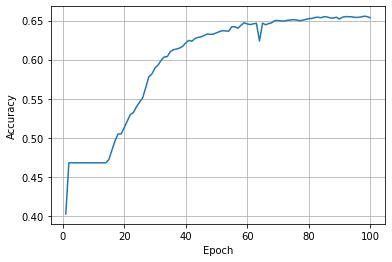

In [26]:
import matplotlib.pyplot as plt
import numpy as np
epoch = np.arange(1, len(acc_list) + 1, 1)
acc_list = np.array(acc_list)
plt.plot(epoch, acc_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

#### 尝试使用分类器进行预测

In [25]:
# 处理单个名字
def make_data(input_name):
    sequences_and_lengths_pre = [name2list(input_name)]
    name = [sl[0] for sl in sequences_and_lengths_pre]
    seq_lengths = torch.LongTensor([sl[1] for sl in sequences_and_lengths_pre])
    seq_tensor = torch.zeros(len(name), seq_lengths.max()).long()
    for idx, (seq, seq_len) in enumerate(zip(name, seq_lengths), 0):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)
    # sort by length to use pack_padded_sequence
    seq_lengths, perm_idx = seq_lengths.sort(dim=0, descending=True)
    seq_tensor = seq_tensor[perm_idx]
    return seq_tensor, seq_lengths



def guess():
    name = input('Please input your name: ')
    inputs,sql_len = make_data(name)
    # 得到预测
    output = classifier(inputs,sql_len)
    pred = output.max(dim=1, keepdim=True)[1]

    # 进行国家转化
    coun = testset.country_list[pred.data.item()]
    print('Hi!',name,'.  I guess you come from :',coun,end=' ')
    print()


guess()

Hi! Zhouyuzhe .  I guess you come from : Russian 
